### Corrective RAG

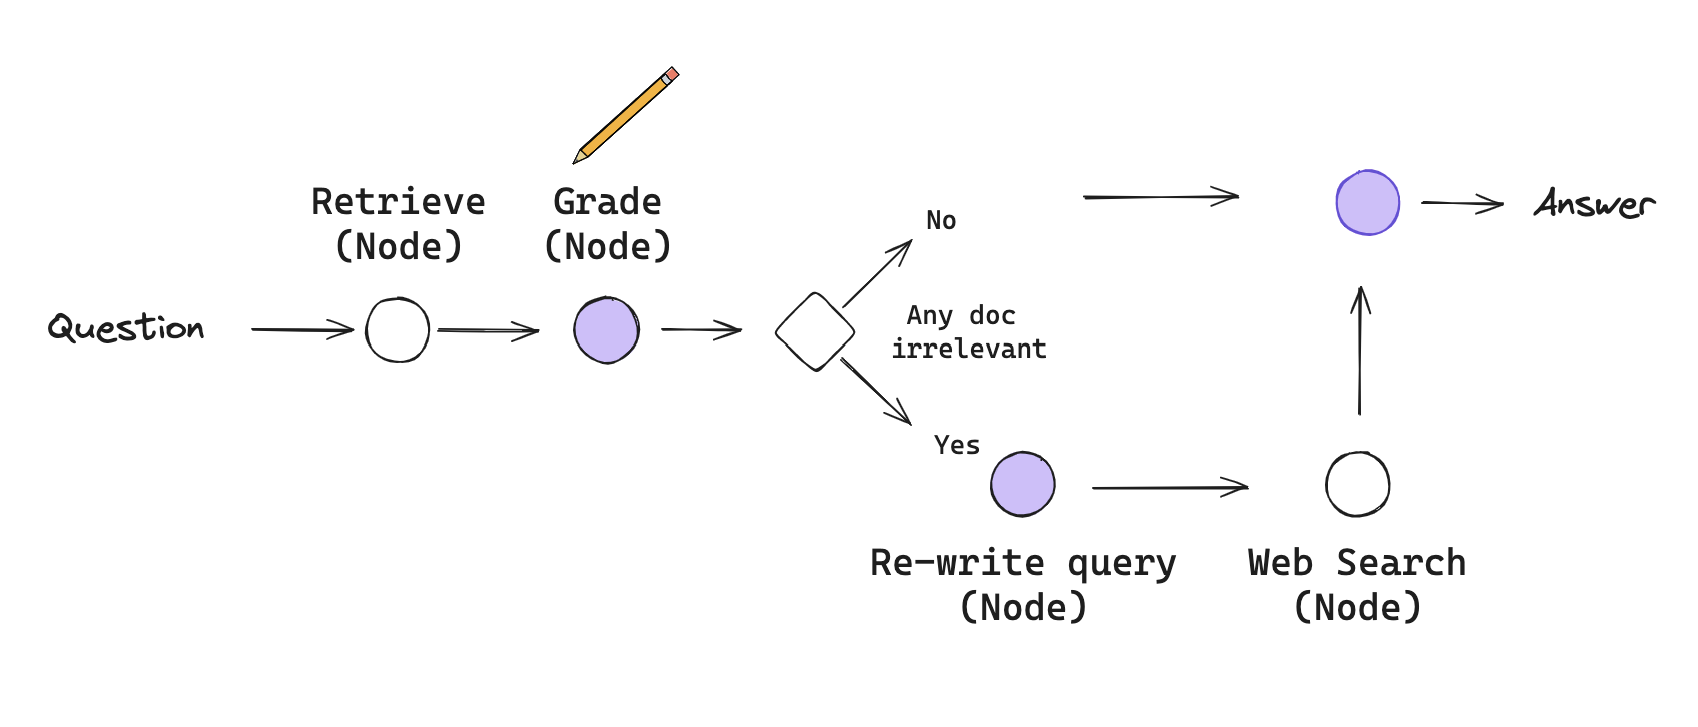

In [35]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [36]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
# from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = OllamaEmbeddings(model="gemma:2b")

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OllamaEmbeddings(model="gemma:2b")
)


retriever=vectorstore.as_retriever()

In [37]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm=ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [38]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The context discusses LLM-powered autonomous agents, which include a component called "Memory" that can be either short-term or long-term. Short-term memory utilizes in-context learning, while long-term memory leverages an external vector store and fast retrieval to retain and recall information over extended periods. Therefore, agent memory refers to the capability of an LLM-powered autonomous agent to store and retrieve information.


In [39]:
### Question Re-writer

# LLM
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Based on the input question "agent memory", I\'ve reformulated it to a more specific and optimized version for web search:\n\n"What is agent memory in artificial intelligence and how does it work?"\n\nThis revised question:\n\n* Clarifies the context of "agent memory" to focus on artificial intelligence (AI) and related fields\n* Indicates that the user is seeking a definition and explanation of the concept\n* Is more specific and concise, making it easier for search engines to provide relevant results\n\nAlternatively, other possible reformulations could be:\n\n* "Agent memory definition"\n* "What is episodic memory in agents?"\n* "Agent memory models in AI"\n\nHowever, the first revised question I provided seems to be a good balance of specificity and generality to retrieve relevant information on the topic.'

In [40]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

# web_search_tool = TavilySearchResults(k=3)
web_search_tool = TavilySearchResults()

In [41]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [42]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    # Fix: handle both dict and string results
    web_results = "\n".join([
        d["content"] if isinstance(d, dict) and "content" in d else str(d)
        for d in docs
    ])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [43]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

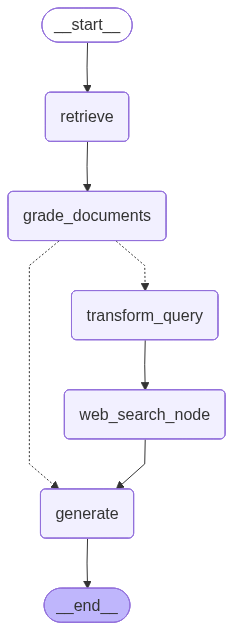

In [44]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [45]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---GENERATE---


{'question': 'Based on the input question, I understand that the user is seeking information on the different categories or classifications of agent memory, likely in the context of artificial intelligence, cognitive science, or robotics.\n\nHere\'s a reformulated, improved question that\'s optimized for web search:\n\n"What are the different types of memory models or architectures used in artificial agents or intelligent systems?"\n\nAlternatively, I can also suggest:\n\n* "What are the various forms of memory in autonomous agents or AI systems?"\n* "What are the classifications of memory in cognitive architectures or intelligent agents?"\n* "Types of agent memory in AI: a list or overview"\n\nThese revised questions are more specific, concise, and include relevant keywords that can help search engines provide more accurate and relevant results.',
 'generation': 'Based on the provided context, the different types of memory in agent systems are: \n\n* Short-term memory: utilized for in